In [1]:
from gensim.models import Word2Vec
import numpy as np
import pandas as pd
import os
import sys
import re
sys.path.insert(0,'/workspace/lang-detect/')

from src import utils

In [2]:
data_path = "/workspace/lang-detect/txt/"
dir_list = os.listdir(data_path)
print(dir_list)

['sl', 'es', 'el', 'nl', 'hu', 'it', 'bg', 'sk', 'da', 'sv', 'cs', 'lt', 'de', 'en', 'pl', 'fr', 'fi', 'lv', 'pt', 'et', 'ro']


In [4]:
def read_data(filepath):
    with open(filepath, "r") as f:
        lines = f.readlines()
        if len(lines) > 1:
            return lines[1].strip("\n")
        return None

In [5]:
%%time
data, labels = [], []
for dir_name in dir_list:
    files_list = os.listdir(data_path + dir_name)
    for f in files_list:
        sent = read_data(data_path + dir_name + "/" + f)
        if sent:
            data.append(sent)
            labels.append(dir_name)
            
test_data, test_labels = [], []
with open("../../europarl.test", "r") as f:
    for line in f:
        line = line.split()
        test_data.append(" ".join(line[1:]))
        test_labels.append(line[0])

print(test_data[0], test_labels[0])

('"\xd0\x95\xd0\xb2\xd1\x80\xd0\xbe\xd0\xbf\xd0\xb0 2020" \xd0\xbd\xd0\xb5 \xd1\x82\xd1\x80\xd1\x8f\xd0\xb1\xd0\xb2\xd0\xb0 \xd0\xb4\xd0\xb0 \xd1\x81\xd1\x82\xd0\xb0\xd1\x80\xd1\x82\xd0\xb8\xd1\x80\xd0\xb0 \xd0\xbd\xd0\xbe\xd0\xb2 \xd0\xba\xd0\xbe\xd0\xbd\xd0\xba\xd1\x83\xd1\x80\xd0\xb5\xd0\xbd\xd1\x82\xd0\xb5\xd0\xbd \xd0\xbc\xd0\xb0\xd1\x80\xd0\xb0\xd1\x82\xd0\xbe\xd0\xbd \xd0\xb8 \xd0\xb8\xd0\xb7\xd1\x85\xd0\xbe\xd0\xb4 \xd1\x81 \xd0\xbf\xd1\x80\xd0\xb8\xd0\xb2\xd0\xb0\xd1\x82\xd0\xb8\xd0\xb7\xd0\xb0\xd1\x86\xd0\xb8\xd1\x8f.', 'bg')
CPU times: user 5.8 s, sys: 6.43 s, total: 12.2 s
Wall time: 42.9 s


In [6]:
print("Length of train data", len(data))
print("Length of test data", len(test_data))

('Length of train data', 186458)
('Length of test data', 21000)


In [7]:
%%time
for i in range(len(data)):
    data[i] = utils.preprocess(data[i])

for i in range(len(test_data)):
    test_data[i] = utils.preprocess(data[i])

CPU times: user 1.42 s, sys: 35.4 ms, total: 1.46 s
Wall time: 1.42 s


In [8]:
print(len(data),len(test_data))

(186458, 21000)


In [9]:
sentences, test_sentences = [], []
for i in range(len(data)):
    x = utils.create_n_gram(data[i], 4)
    sentences.append(x.split())

for i in range(len(test_data)):
    x = utils.create_n_gram(data[i], 4)
    test_sentences.append(x.split())

In [23]:
%%time
# Create validation set of random 20000 sentences
rand_indices = np.random.choice(len(sentences), 25000)
rand_indices = list(set(rand_indices))[:20000]
print(len(rand_indices))

valid_sentences, valid_labels = [], []

for ind in rand_indices:
    valid_sentences.append(sentences[ind])
    valid_labels.append(labels[ind])

train_sentences = [j for i,j in enumerate(sentences) if i not in rand_indices]    
train_labels = [j for i,j in enumerate(labels) if i not in rand_indices]

print(len(train_sentences), len(train_labels), len(valid_sentences), len(valid_labels))

20000
(166458, 166458, 20000, 20000)
CPU times: user 11min 7s, sys: 211 ms, total: 11min 7s
Wall time: 11min 7s


In [31]:
import pickle

with open("../data/train_sentences.npy","wb") as f:
    pickle.dump(train_sentences, f)
    
with open("../data/train_labels.npy","wb") as f:
    pickle.dump(train_labels, f)

with open("../data/valid_sentences.npy","wb") as f:
    pickle.dump(valid_sentences, f)
    
with open("../data/valid_labels.npy","wb") as f:
    pickle.dump(valid_labels, f)

In [32]:
len(train_sentences)

166458

### **Check Point**

In [33]:
from gensim.models import Word2Vec
import numpy as np
import pandas as pd
import os
import sys
import re
sys.path.insert(0,'/workspace/lang-detect/')

from src import utils
import pickle

with open("../data/train_sentences.npy","r") as f:
    train_sentences = pickle.load(f)
    
with open("../data/train_labels.npy","r") as f:
    train_labels = pickle.load(f)

with open("../data/valid_sentences.npy","r") as f:
    valid_sentences = pickle.load(f)
    
with open("../data/valid_labels.npy","r") as f:
    valid_labels = pickle.load(f)
    
print(len(train_sentences), len(train_labels), len(valid_sentences), len(valid_labels))

(166458, 166458, 20000, 20000)


In [34]:
# Create word_to_index and index_to_word mapping
PAD_ID = 0
UNK_ID = 1

word_to_index, index_to_word, word_freq = {}, {}, {}

index = 2
for sent in train_sentences:
    for token in sent:
        if token not in word_to_index:
            word_freq[token] = 1
            word_to_index[token] = index
            index_to_word[index] = token
            index += 1
        else:
            word_freq[token] += 1

print("Vocabulary size", index-1)

('Vocabulary size', 81433)


In [37]:
classes = {}
for ind, c in enumerate(list(set(train_labels))):
    classes[c] = ind
print(classes)

{'el': 0, 'fr': 1, 'bg': 2, 'nl': 3, 'es': 20, 'pt': 5, 'da': 19, 'de': 8, 'sv': 7, 'it': 9, 'lv': 6, 'lt': 13, 'en': 14, 'sk': 11, 'sl': 16, 'cs': 17, 'et': 12, 'hu': 10, 'ro': 4, 'fi': 18, 'pl': 15}


In [35]:
less_freq = 0
for k,v in word_freq.items():
    if v <= 1:
        less_freq += 1
print(less_freq)

14093


In [38]:
# Change words to their index
def get_indexed_data(sentences, data_type=None):
    data_x = []
    for sent in sentences:
        x = []
        for token in sent:
            if token in word_to_index:
                if (data_type == "train") and (word_freq[token] == 1):
                    x.append(UNK_ID)
                else:
                    x.append(word_to_index[token])
            else:
                x.append(UNK_ID)
        data_x.append(x)
    return data_x

def get_indexed_label(labels):
    data_y = [classes[x] for x in labels]
    return data_y

train_x = get_indexed_data(train_sentences, "train")
valid_x = get_indexed_data(valid_sentences)
test_x = get_indexed_data(test_sentences)

train_y = get_indexed_label(train_labels)
valid_y = get_indexed_label(valid_labels)
test_y = get_indexed_label(test_labels)

print(len(train_x),len(valid_x),len(test_x))
print(len(train_y),len(valid_y),len(test_y))

(166458, 20000, 21000)
(166458, 20000, 21000)


In [39]:
# Check distribution of length of sentences
def get_dist(x):
    lens = {}
    for sent in x:
        if len(sent) in lens:
            lens[len(sent)] += 1
        else:
            lens[len(sent)] = 1
    return lens
        
train_lens = get_dist(train_x)
valid_lens = get_dist(valid_x)
test_lens = get_dist(test_x)

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline  

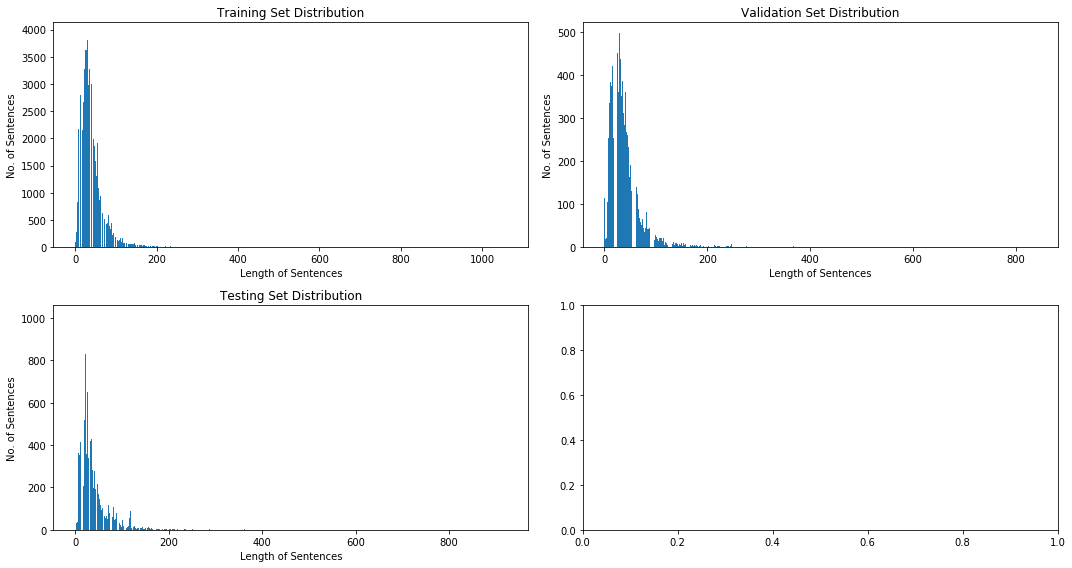

<Figure size 720x360 with 0 Axes>

In [66]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,8))

plt.subplot(221)
plt.bar(train_lens.keys(), train_lens.values())
plt.title("Training Set Distribution")
plt.xlabel('Length of Sentences')
plt.ylabel('No. of Sentences')

plt.subplot(222)
plt.bar(valid_lens.keys(), valid_lens.values())
plt.title("Validation Set Distribution")
plt.xlabel('Length of Sentences')
plt.ylabel('No. of Sentences')

plt.subplot(223)
plt.bar(test_lens.keys(), test_lens.values())
plt.title("Testing Set Distribution")
plt.xlabel('Length of Sentences')
plt.ylabel('No. of Sentences')
plt.figure(figsize=(10,5))

fig.tight_layout()
plt.show()

Training, Validation and Testing set have similar distribution. Also most of the sentences have length less than 250.

In [68]:
# in train check number of sentences with length more than 100, 200, 300
def check_sent_length_buckets(len_dists):
    n_100, n_200, n_250, n_300, n_500 = 0, 0, 0, 0, 0
    for k,v in len_dists.items():
        if k >= 500:
            n_500 += v
        if k >= 300:
            n_300 += v
        if k >= 200:
            n_200 += v
        if k >= 250:
            n_250 += v
        if k >= 100:
            n_100 += v
    print(n_100, n_200, n_250, n_300, n_500)

check_sent_length_buckets(train_lens)
check_sent_length_buckets(valid_lens)
check_sent_length_buckets(test_lens)

(7356, 1024, 459, 226, 37)
(973, 134, 55, 31, 7)
(1172, 172, 74, 38, 4)


**There are some very long sentences but I don't want to loose information. What I am going to do is, truncate the sentences with length more than 250 and create a new sentence from index 251 to 500 and so on. This will be done only for train. Since I have included 4-gram tokens only in this data, some noise might get added at the start and end of new sentences, but the model should not get affected by that.**

In [69]:
train_x_trunc, train_y_trunc = [], []

max_len = 250

for ind, sent in enumerate(train_x):
    while(len(sent) > max_len):
        train_x_trunc.append(sent[:max_len])
        train_y_trunc.append(train_y[ind])
        sent = sent[max_len:]
    train_x_trunc.append(sent)
    train_y_trunc.append(train_y[ind])

print(len(train_x_trunc), len(train_y_trunc))

(166959, 166959)


##### **Create batches**

In [70]:
train_lens = get_dist(train_x)

In [71]:
buckets = [10*x for x in range(1,26)]
buckets_data_sum = {}
for k, v in train_lens.items():
    for x in buckets:
        if k <= x:
            if x in buckets_data_sum:
                buckets_data_sum[x] += v
            else:
                buckets_data_sum[x] = v
            break
buckets_data_sum

{10: 12360,
 20: 29864,
 30: 35436,
 40: 30341,
 50: 20243,
 60: 12470,
 70: 7462,
 80: 4815,
 90: 3905,
 100: 2363,
 110: 1569,
 120: 1365,
 130: 860,
 140: 585,
 150: 504,
 160: 429,
 170: 321,
 180: 226,
 190: 176,
 200: 155,
 210: 133,
 220: 133,
 230: 93,
 240: 87,
 250: 107}

In [72]:
sum(buckets_data_sum.values())

166002

In [74]:
from collections import defaultdict

# Create batch data
def create_batches(data_x, data_y):
    batch_data = defaultdict(list)
    batch_label = defaultdict(list)

    for ind, sent in enumerate(data_x):
        for x in buckets:
            if len(sent) <= x:
                sent += [PAD_ID]*(x - len(sent))
                batch_data[x].append(sent)
                batch_label[x].append(data_y[ind])
                break
    
    return batch_data, batch_label

train_batch_data, train_batch_labels = create_batches(train_x_trunc, train_y_trunc)
valid_batch_data, valid_batch_labels = create_batches(valid_x, valid_y)

In [75]:
train_batch_data[10][:10]

[[305, 306, 307, 293, 308, 71, 309, 0, 0, 0],
 [361, 59, 60, 61, 62, 63, 64, 144, 0, 0],
 [361, 59, 60, 61, 62, 63, 64, 144, 0, 0],
 [640, 641, 642, 643, 644, 645, 646, 309, 0, 0],
 [361, 59, 60, 61, 62, 63, 64, 144, 0, 0],
 [640, 641, 642, 643, 644, 645, 646, 309, 0, 0],
 [781, 782, 783, 440, 784, 785, 786, 787, 788, 789],
 [361, 59, 60, 61, 62, 63, 64, 144, 0, 0],
 [640, 641, 642, 643, 644, 645, 646, 309, 0, 0],
 [305, 306, 307, 293, 308, 71, 309, 0, 0, 0]]

In [77]:
# Convert to numpy array each key
def to_numpy_array(batch_data, batch_label):
    for key in batch_data:
        batch_data[key] = np.array(batch_data[key])
        batch_label[key] = np.array(batch_label[key])
    return batch_data, batch_label

train_batch_data, train_batch_labels = to_numpy_array(train_batch_data, train_batch_labels)
valid_batch_data, valid_batch_labels = to_numpy_array(valid_batch_data, valid_batch_labels)
test_data, test_labels = np.array(test_x), np.array(test_y)

In [79]:
import pickle

train = {'data':train_batch_data, 'labels':train_batch_labels}
valid = {'data':valid_batch_data, 'labels':valid_batch_labels}
test = {'data':test_data, 'labels':test_labels}

with open('../data/train_batch.npy', 'w') as f:
    pickle.dump(train, f)

with open('../data/valid_batch.npy', 'w') as f:
    pickle.dump(valid, f)
    
with open('../data/test_data.npy', 'w') as f:
    pickle.dump(test, f)

In [80]:
# Create embedding matrix
wordvec = Word2Vec.load("../word-vectors/word2vec")
wordvec.wv.most_similar("the")

/usr/local/lib/python2.7/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('and', 0.7841068506240845),
 ('on', 0.759896993637085),
 ('of', 0.7271450757980347),
 ('fety', 0.7232488393783569),
 ('shor', 0.7075440883636475),
 ('ourt', 0.7063887119293213),
 ('din', 0.7044749855995178),
 ('to', 0.7022175192832947),
 ('afet', 0.6996240019798279),
 ('from', 0.691842794418335)]

In [81]:
wordvec.wv.get_vector("the")

array([ 1.572987  ,  2.735609  ,  0.64099294,  2.2075114 ,  1.810811  ,
        1.320163  , -2.0518892 ,  0.6383124 ,  1.5301269 , -1.8204945 ,
        0.87725013, -0.9785473 , -2.4711254 ,  1.0467197 , -0.43357244,
       -0.37392902, -3.4508646 , -0.87442845, -0.46869975,  0.5089424 ,
        2.6256225 , -2.4643495 ,  2.2892654 , -0.29851928,  1.6183301 ,
        2.48107   ,  0.21856466, -0.5068994 , -1.7413462 , -1.1562588 ,
       -2.8360653 , -3.4761653 ,  2.6883032 ,  1.8478122 , -0.94803345,
       -1.5750355 , -1.3575674 , -0.49536067,  1.0757141 ,  0.5275996 ,
       -1.9814926 , -2.2281053 , -1.6347038 ,  1.3217245 ,  1.9017682 ,
        2.1075456 , -0.41398883,  3.4355843 , -0.00692933, -2.4787297 ,
       -0.9633201 ,  2.0556319 ,  0.47517714, -4.1312013 ,  1.4229084 ,
        0.8764478 , -0.10577996, -2.3738363 , -0.73883134, -1.2658491 ,
       -2.68997   ,  0.40155867,  0.3440695 ,  2.4353578 , -0.28661215,
        1.7299148 , -3.2678797 , -0.93289286,  0.552735  ,  3.13

Tokens are indexed from 2. '0' is for the padding and '1' for unknown token. Vector for 0 will be zero-vector and for 1, a random vector.

In [82]:
vocab_size, embed_size = wordvec.wv.vectors.shape

In [83]:
sorted_word_to_index = sorted(zip(word_to_index.keys(), word_to_index.values()), key=lambda x: x[1])
sorted_word_to_index[0]

('pred', 2)

In [84]:
embedding_matrix = []
embedding_matrix.append([0.]*embed_size)
embedding_matrix.append(np.random.uniform(-3, 3, embed_size))

for key, index in sorted_word_to_index:
    embedding_matrix.append(wordvec.wv.get_vector(key))

In [85]:
print(len(embedding_matrix), len(embedding_matrix[0]))

(81434, 100)


In [86]:
embedding_matrix = np.array(embedding_matrix)

import pickle
with open('../data/embedding_matrix.npy', 'w') as f:
    pickle.dump(embedding_matrix, f)

In [87]:
with open('../data/embedding_matrix.npy', 'r') as f:
    ld = pickle.load(f)
ld.shape

(81434, 100)